# State Income and Firearm Murders

### Methodology

**Project Goal**: Analyze the relationship between state population and firearm murder in the United States between 2000 and 2010

**Independent Variables**: % of Murders Committed with Firearm (by year and state), Firearm Murders per 100k (by year and state)

**Dependent Variable**: Median Income (by year and state)


A Linear Regression model is used to determine the relationship between the independent and dependent variables.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style('darkgrid')

# Importing / Cleaning Data

In [2]:
# Import data containing records of reported murders for each state
crime = pd.read_csv('database.csv')

In [3]:
crime.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [4]:
# Import data containing yearly state population
pop = pd.read_csv('population.csv')

pop = pop.drop_duplicates(subset='NAME')

pop.drop(['REGION', 'DIVISION', 'STATE', 'SEX', 'ORIGIN', 'RACE', 'AGEGRP', 'ESTIMATESBASE2000', 'CENSUS2010POP'], axis=1, inplace=True)


pop.rename({'POPESTIMATE2000' : '2000', 'POPESTIMATE2001' : '2001', 'POPESTIMATE2002' :'2002', 'POPESTIMATE2003' : '2003', 'POPESTIMATE2004' : '2004', 
           'POPESTIMATE2005' : '2005', 'POPESTIMATE2006' : '2006', 'POPESTIMATE2007' : '2007', 'POPESTIMATE2008' : '2008', 'POPESTIMATE2009' : '2009', 'POPESTIMATE2010' : '2010'}, axis=1, inplace=True)

pop = pop.melt(id_vars=['NAME'], var_name='Year')



pop.columns = ['State', 'Year', 'Population']
pop['Year'] = pop['Year'].astype(int)

pop.head()

,State,Year,Population
0,United States,2000,282162411
1,Alabama,2000,4452173
2,Alaska,2000,627963
3,Arizona,2000,5160586
4,Arkansas,2000,2678588


In [5]:
# Import data containing yearly median income by state
income = pd.read_csv('household_median_income_2017.csv')

income = income.melt(id_vars=['State'], var_name='Year')

income.dropna(inplace=True)
income['value'] = income['value'].apply(lambda x : x.replace(',', '')).astype(int)
income = income[income['Year'] != '2013.1']
income['State'] = income['State'].astype(str)
income['Year'] = income['Year'].astype(int)
income.head()

,State,Year,value
0,United States,2017,61372
1,Alabama,2017,51113
2,Alaska,2017,72231
3,Arizona,2017,61125
4,Arkansas,2017,48829


In [6]:
income.tail()

,State,Year,value
1849,Virginia,1984,59772
1850,Washington,1984,56374
1851,West Virginia,1984,37955
1852,Wisconsin,1984,46743
1853,Wyoming,1984,53668


# Merge Data 

In [7]:
# Label data with 1 if the crime was committed with a firearm, else label with 0
crime['Firearm'] = crime['Weapon'].apply(lambda x : 1 if (x == 'Handgun' or x == 'Firearm' or x == 'Shotgun' or x == 'Rifle' or x =='Gun') else 0)

In [8]:
# Keep a column containing all 1's to get the total rows when grouping
crime['Count']  = 1

# Group Crime, Income, and Population datasets together 
firearms = crime.groupby(['State', 'Year']).sum().reset_index()

In [9]:
firearms = firearms.merge(income, on=['State', 'Year'])
firearms = firearms.merge(pop, on=['State', 'Year'])


firearms = firearms[['State', 'Year', 'Victim Count', 'Perpetrator Count', 'Firearm', 'Count', 'value', 'Population']]

firearms.rename({'Count' : 'Total', 'value' : 'Income'}, axis=1, inplace=True)

#Our dataset now has rows containing a State, Year, # of Murders Committed by a Firearm, Total Murders, Income, and Population
firearms.head()

,State,Year,Victim Count,Perpetrator Count,Firearm,Total,Income,Population
0,Alabama,2000,4,2,152,235,50566,4452173
1,Alabama,2001,48,4,227,347,48800,4467634
2,Alabama,2002,8,1,190,292,51380,4480089
3,Alabama,2003,6,0,209,295,49774,4503491
4,Alabama,2004,0,0,162,253,47651,4530729


# Feature Engineering

In [10]:
# Get the % of Murders committed by a firearm by dividing the number of firearm murders by total murders
firearms['Firearm%'] = firearms['Firearm'] / firearms['Total']

# Get firearm/100k residents by dividing number of firearm murders by population, and multiplying by 100,000
firearms['Firearm/100k'] = (firearms['Firearm'] / firearms['Population']) * 100000

firearms.head()

,State,Year,Victim Count,Perpetrator Count,Firearm,Total,Income,Population,Firearm%,Firearm/100k
0,Alabama,2000,4,2,152,235,50566,4452173,0.646809,3.414063
1,Alabama,2001,48,4,227,347,48800,4467634,0.654179,5.080989
2,Alabama,2002,8,1,190,292,51380,4480089,0.650685,4.240987
3,Alabama,2003,6,0,209,295,49774,4503491,0.708475,4.640844
4,Alabama,2004,0,0,162,253,47651,4530729,0.640316,3.575584


In [11]:
firearms.tail()

,State,Year,Victim Count,Perpetrator Count,Firearm,Total,Income,Population,Firearm%,Firearm/100k
534,Wyoming,2006,0,0,5,9,57332,522667,0.555556,0.956632
535,Wyoming,2007,0,1,8,18,57769,534876,0.444444,1.495674
536,Wyoming,2008,0,4,4,10,60875,546043,0.400000,0.732543
537,Wyoming,2009,4,6,8,12,60094,559851,0.666667,1.428952
538,Wyoming,2010,0,2,5,8,58816,564460,0.625000,0.885802


# Exploratory Data Analysis

In [12]:
# Get average values for each state
states = firearms.groupby('State').mean()

states.head()

,Year,Victim Count,Perpetrator Count,Firearm,Total,Income,Population,Firearm%,Firearm/100k
State,,,,,,,,,
Alabama,2005.0,12.000000,3.363636,211.636364,304.181818,48533.545455,4.597017e+06,0.691159,4.600880
Alaska,2005.0,5.818182,5.727273,22.636364,40.090909,71869.090909,6.667815e+05,0.563827,3.397417
Arizona,2005.0,63.818182,61.818182,321.363636,444.545455,55537.181818,5.824203e+06,0.720883,5.561338
Arkansas,2005.0,23.818182,35.636364,113.000000,166.181818,44666.000000,2.790464e+06,0.681271,4.049104
California,2005.0,270.909091,430.272727,1726.363636,2383.818182,65114.636364,3.574376e+07,0.722649,4.839566


### Firearm % by State

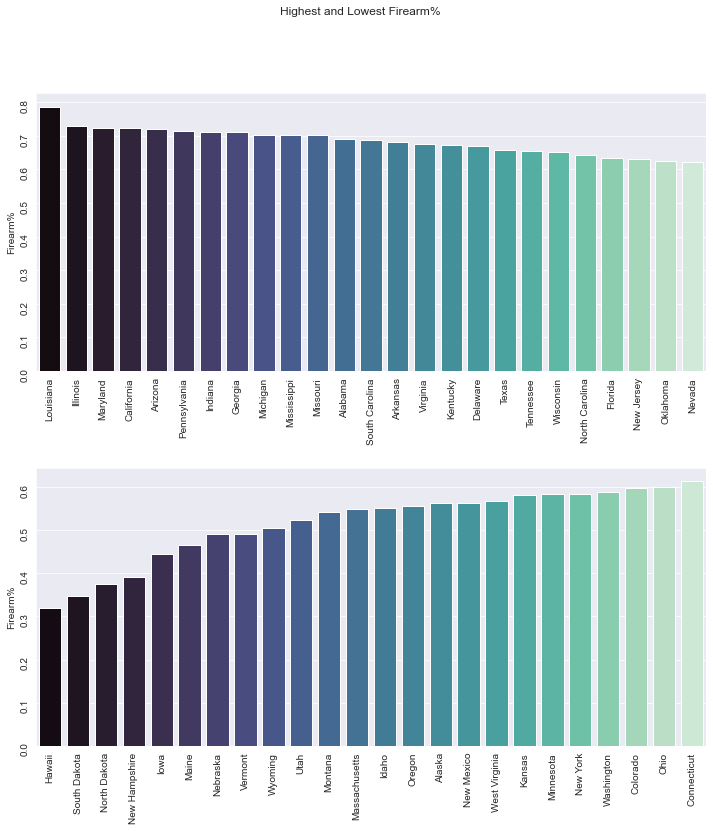

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (12,12))

top25states = states.sort_values('Firearm%', ascending=False).head(25)
bottom25states = states.sort_values('Firearm%', ascending=True).head(24)

sns.barplot(x = top25states.index, y = 'Firearm%', data = top25states, ax = ax1, palette = 'mako')
sns.barplot(x = bottom25states.index, y = 'Firearm%', data = bottom25states, ax = ax2, palette = 'mako')

ax1.set_xlabel('')
ax2.set_xlabel('')
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Highest and Lowest Firearm%')
fig.subplots_adjust(hspace=.35)

plt.show()

### Firearm/100k by State

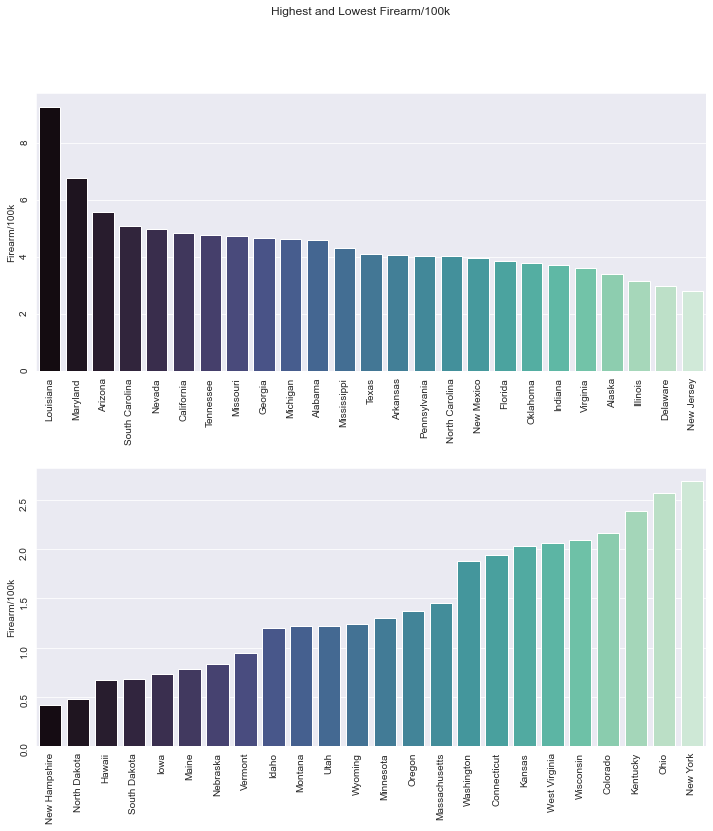

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (12,12))

top25states_100k = states.sort_values('Firearm/100k', ascending=False).head(25)
bottom25states_100k = states.sort_values('Firearm/100k', ascending=True).head(24)

sns.barplot(x = top25states_100k.index, y = 'Firearm/100k', data = top25states_100k, ax = ax1, palette = 'mako')
sns.barplot(x = bottom25states_100k.index, y = 'Firearm/100k', data = bottom25states_100k, ax = ax2, palette = 'mako')


for ax in fig.axes:
    ax.tick_params(labelrotation=90)

ax1.set_xlabel('')
ax2.set_xlabel('')
fig.suptitle('Highest and Lowest Firearm/100k')

fig.subplots_adjust(hspace=.35)

plt.show()

### Average Income, binned by Firearm%

Text(0.5, 1.0, 'Average Income, binned by Firearm%')

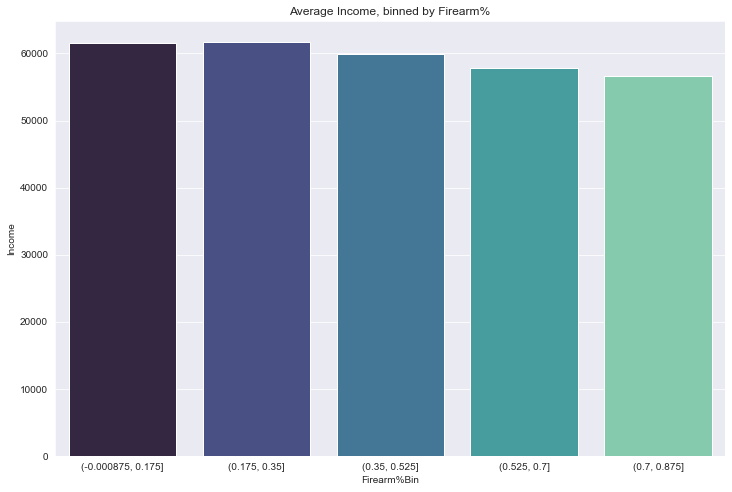

In [15]:
firearms['Firearm%Bin'] = pd.cut(firearms['Firearm%'], bins=5).values

binned = firearms.groupby('Firearm%Bin').mean()

fig = plt.figure(figsize = (12, 8))
sns.barplot(x = binned.index, y = 'Income', data = binned, palette='mako')

plt.title('Average Income, binned by Firearm%')

### Average Income, binned by Firearm/100k

Text(0.5, 1.0, 'Average Income, binned by Firearm/100k')

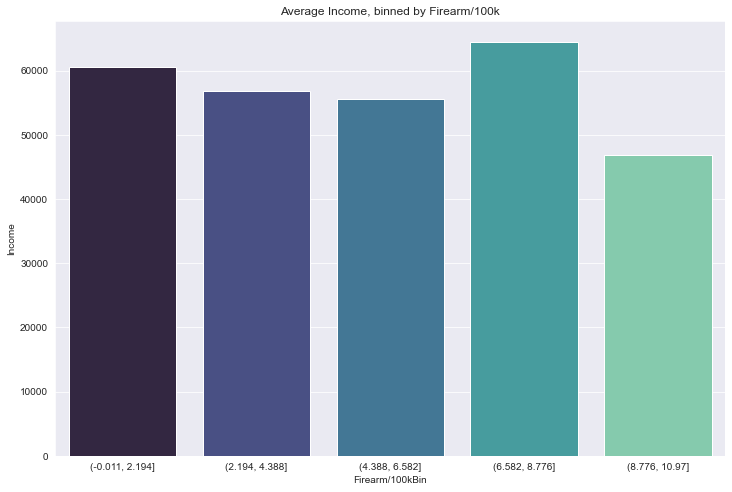

In [16]:
firearms['Firearm/100kBin'] = pd.cut(firearms['Firearm/100k'], bins=5).values

binned = firearms.groupby('Firearm/100kBin').mean()

fig = plt.figure(figsize = (12, 8))
sns.barplot(x = binned.index, y = 'Income', data = binned, palette='mako')


plt.title('Average Income, binned by Firearm/100k')

### Correlation Matrix

In [17]:
firearms_corr = firearms[['Income', 'Population', 'Firearm%', 'Firearm/100k']]

<AxesSubplot:>

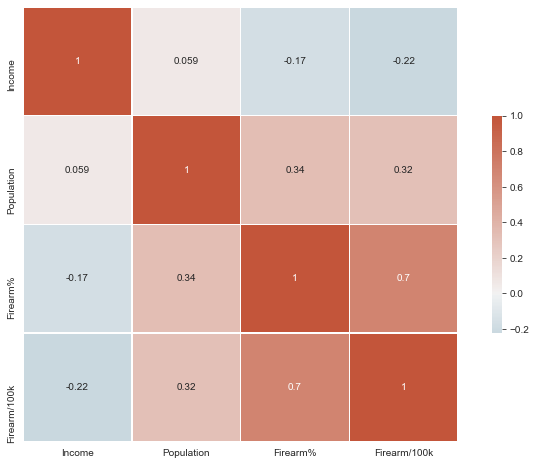

In [18]:
corr = firearms_corr.corr()
fig = plt.figure(figsize=(12,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)



# Regression Model

### Firearm/100k and Income

In [19]:
import statsmodels.api  as sm

In [20]:
X = sm.add_constant(firearms['Firearm/100k'])
Y = firearms['Income']

results = sm.OLS(Y,X).fit()

In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Income   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     28.22
Date:                Tue, 09 Feb 2021   Prob (F-statistic):           1.59e-07
Time:                        10:00:20   Log-Likelihood:                -5655.0
No. Observations:                 539   AIC:                         1.131e+04
Df Residuals:                     537   BIC:                         1.132e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.125e+04    696.824     87.896      0.000    5.99e+04    6.26e+04
Firearm/100k -1045.7014    196.862     -5.312      0.000   -1432.416    -658.987
==============================================================================
Omnibus:                       20.667   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.414
Skew:                           0.462   Prob(JB):                     2.24e-05
Kurtosis:                       2.686   Cond. No.                         6.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

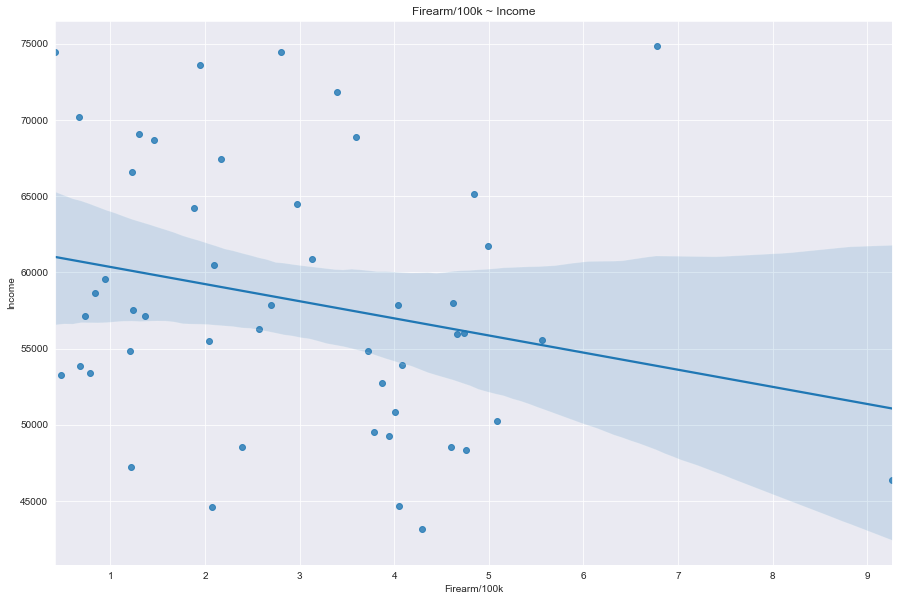

In [22]:
fig = plt.figure(figsize = (15,10))
sns.regplot(x='Firearm/100k', y = 'Income', data = states)

plt.title('Firearm/100k ~ Income')

plt.show()

In [23]:
X = sm.add_constant(firearms['Firearm%'])
Y = firearms['Income']

results = sm.OLS(Y,X).fit()

In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Income   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     15.28
Date:                Tue, 09 Feb 2021   Prob (F-statistic):           0.000104
Time:                        10:00:20   Log-Likelihood:                -5661.2
No. Observations:                 539   AIC:                         1.133e+04
Df Residuals:                     537   BIC:                         1.133e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.472e+04   1726.796     37.478      0.000    6.13e+04    6.81e+04
Firearm%   -1.093e+04   2795.274     -3.909      0.000   -1.64e+04   -5436.288
==============================================================================
Omnibus:                       26.289   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.882
Skew:                           0.393   Prob(JB):                     2.92e-05
Kurtosis:                       2.441   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

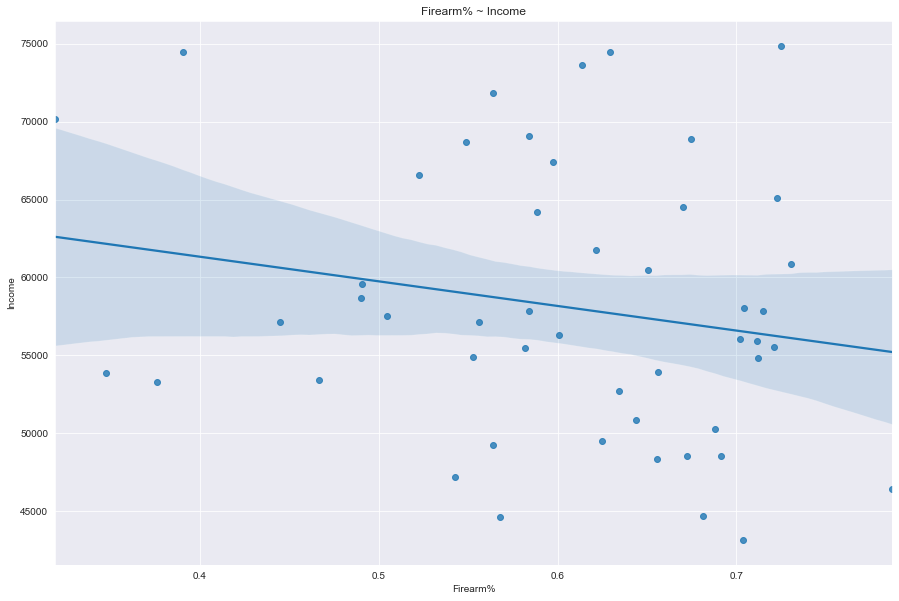

In [25]:
fig = plt.figure(figsize = (15,10))
sns.regplot(x='Firearm%', y = 'Income', data = states)

plt.title('Firearm% ~ Income')
plt.show()